In [1]:
import os
import sys

import pandas as pd

sys.path.append(os.path.abspath(".."))
from models.xgboost import (create_features_and_targets, create_model,
                            evaluate_model, get_autocorrelation_lags,
                            train_model)
from utils.plotting import plot_train_val, plot_usage
from utils.preprocess import (add_spotprice, add_time_based_features,
                              add_weather_forecast, interpolate_missing_hours,
                              split_train_val)

In [2]:
df_raw = pd.read_csv('../data/cons_sthlm_mean_large.csv')

df = interpolate_missing_hours(df_raw)
df = add_time_based_features(df)

spot_price_path = '../data/spotprices.csv'
se_area = 'SE3'
df = add_spotprice(df, spot_price_path, se_area)

weather_path = '../data/open-meteo-stockholm.csv'
#columns_to_add = ['temperature_2m', 'precipitation', 'wind_speed_10m', 'uv_index', 'direct_radiation', 'diffuse_radiation']
columns_to_add = ['temperature_2m', 'precipitation', 'direct_radiation', 'uv_index', 'wind_speed_10m']
df = add_weather_forecast(df, weather_path, columns_to_add)

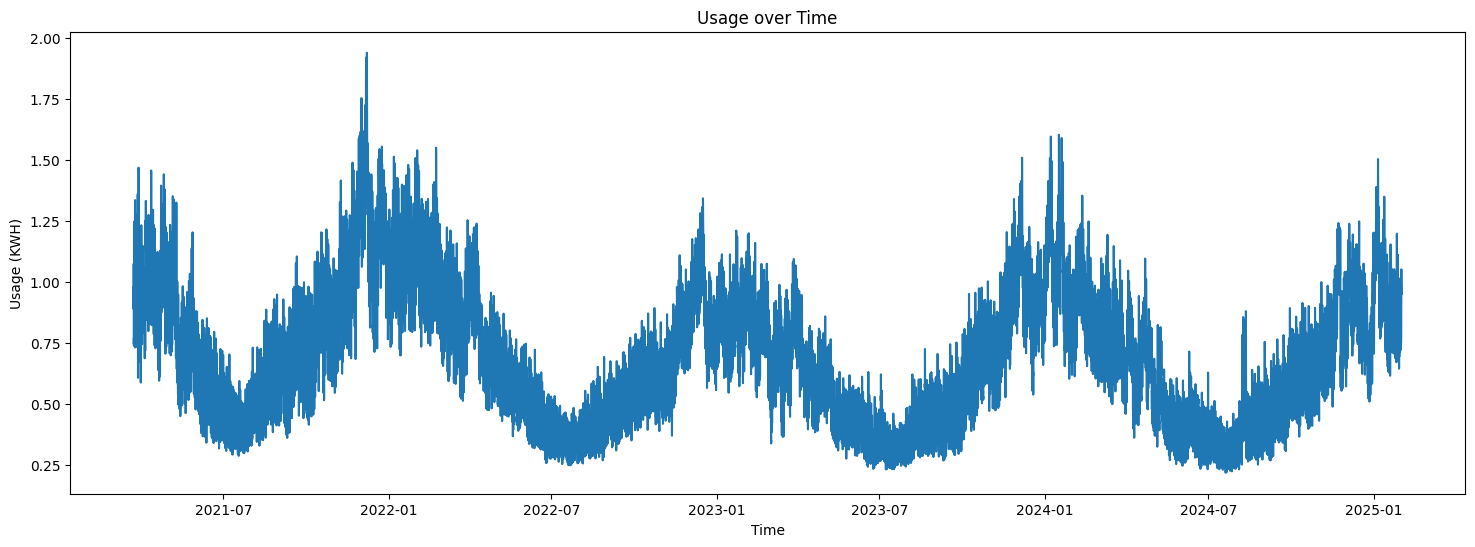

In [3]:
plot_usage(df)

In [4]:
df

,USAGE_AT,MONTH,DAY_OF_MONTH,WEEKDAY,HOUR,SPOTPRICE_SEK_BY_KWH,temperature_2m,precipitation,direct_radiation,uv_index,wind_speed_10m,USAGE_KWH
0,2021-03-23 00:00:00+00:00,3,23,1,0,0.28302,2.6,0.0,0.0,0.0,7.1,0.976258
1,2021-03-23 01:00:00+00:00,3,23,1,1,0.27808,2.6,0.0,0.0,0.0,7.1,0.964150
2,2021-03-23 02:00:00+00:00,3,23,1,2,0.26894,2.5,0.0,0.0,0.0,7.2,0.953400
3,2021-03-23 03:00:00+00:00,3,23,1,3,0.27642,2.4,0.0,0.0,0.0,7.2,0.889413
4,2021-03-23 04:00:00+00:00,3,23,1,4,0.42936,2.3,0.0,0.0,0.0,7.6,0.908430
...,...,...,...,...,...,...,...,...,...,...,...,...
33860,2025-01-31 20:00:00+00:00,1,31,4,20,0.88248,0.7,0.0,0.0,0.0,13.3,0.985828
33861,2025-01-31 21:00:00+00:00,1,31,4,21,0.86239,0.3,0.0,0.0,0.0,14.4,0.993425
33862,2025-01-31 22:00:00+00:00,1,31,4,22,0.51394,-0.0,0.0,0.0,0.0,14.4,0.987878
33863,2025-01-31 23:00:00+00:00,1,31,4,23,0.37785,-0.2,0.0,0.0,0.0,14.8,0.969646


In [5]:
autocorr_indexes = get_autocorrelation_lags(df)

Top 3 lags:
[[24, 0.9484993950877721], [25, 0.9365858629443371], [48, 0.9110621409077085]]


In [6]:
X, y = create_features_and_targets(df, forecast_horizon=24, lags=autocorr_indexes)

print(X.shape, y.shape)

(33793, 13) (33793,)


In [7]:
train_split = 0.9
scaler_type = 'minmax'

X_train, y_train, X_val, y_val, scaler_x, scaler_y = split_train_val(X, y, train_split, scaler_type, device=None)

Applying minmax scaling.
X_train shape: (30413, 13)
y_train shape: (30413, 1)
X_val shape: (3380, 13)
y_val shape: (3380, 1)


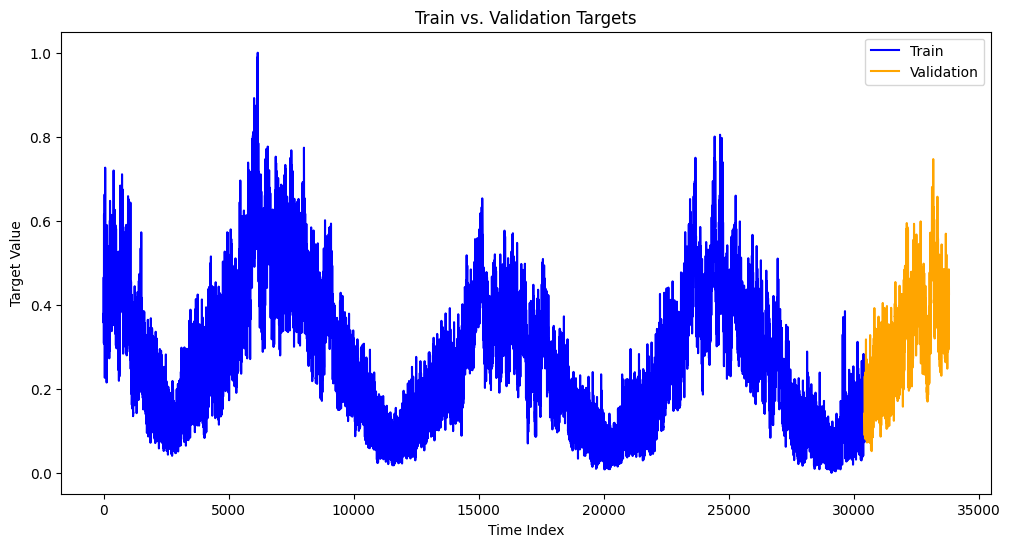

In [8]:
plot_train_val(y_train, y_val)

In [9]:
n_estimators = 10000
lr = 0.05
random_state = 42

model = create_model(n_estimators, lr, random_state)

model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [10]:
trained_model = train_model(model, X_train, y_train)

MAE: 0.0702
MAPE: 9.47%
RMSE: 0.0941
kWh actual: 2545.224125707411, kWh pred: 2545.939453125, diff (%): 0.028104692642346694


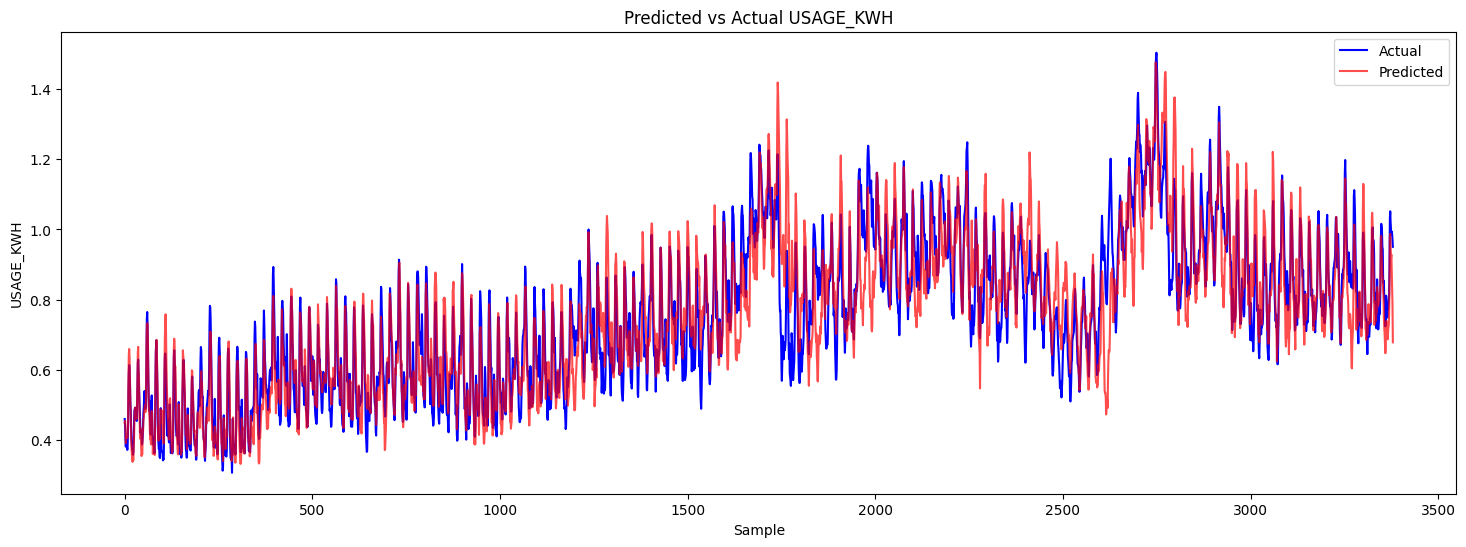

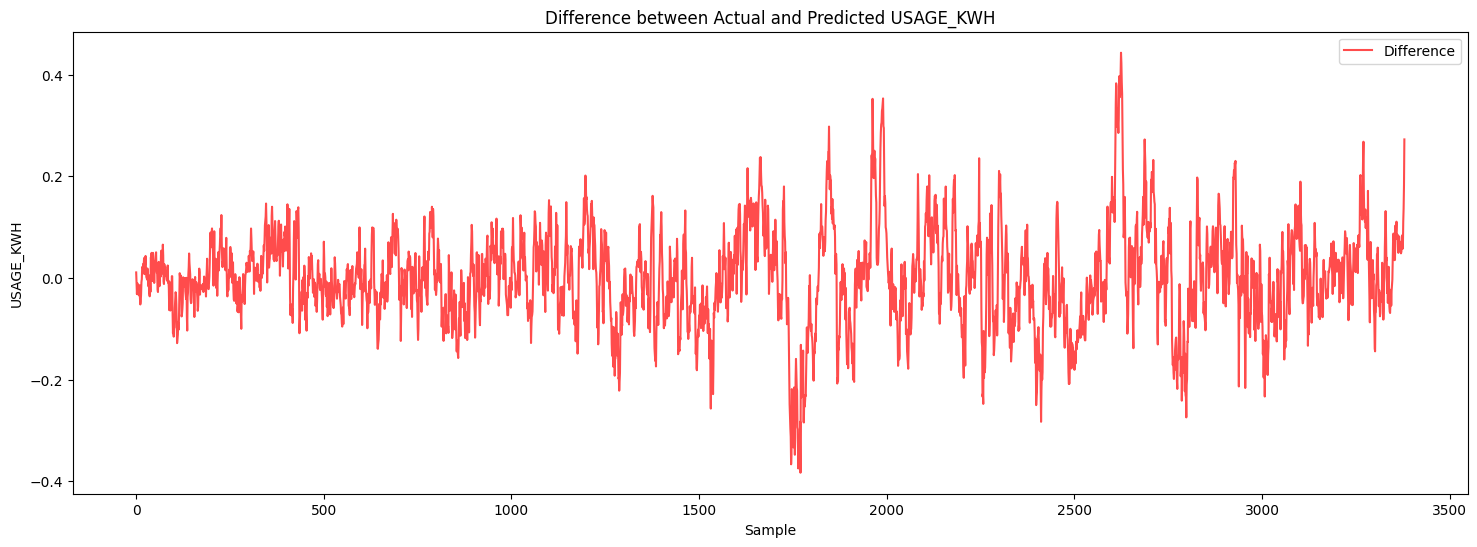

In [11]:
_ = evaluate_model(trained_model, X_val, y_val, scaler_y)